In [1]:
# PACKAGES
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import numpy as np
import ast
import os
import h5py
import scipy
import pandas as pd

from sklearn import metrics
from scipy import stats as ss
import matplotlib as mpl

%matplotlib inline
from scipy import stats

import seaborn as  sns
import pickle
from itertools import chain, combinations

/home/nbbwang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
path_to_ROSMAP_subsets_CV_results = "../../Pipeline_Outputs_Submitted/origGE/results/MTL/ROSMAP_CV_subsets_results.csv"

In [3]:
cmap=plt.cm.tab20
cmaplist = [cmap(i) for i in range(cmap.N)]
light_phenotype_colors = {"CERAD": cmaplist[3], "PLAQUES": cmaplist[7],  "ABETA_IHC": cmaplist[11], 
                    "BRAAK": cmaplist[5], "TANGLES": cmaplist[1], "TAU_IHC": cmaplist[9]}

phenotype_colors = {"CERAD": cmaplist[2], "PLAQUES": cmaplist[6],  "ABETA_IHC": cmaplist[10], 
                    "BRAAK": cmaplist[4], "TANGLES": cmaplist[0], "TAU_IHC": cmaplist[8]}

In [4]:
# df= pickle.load(open(path_to_ROSMAP_subsets_CV_results, "rb" ) )
df= pd.read_csv(path_to_ROSMAP_subsets_CV_results)
df = df.drop("Fold",axis=1).replace(0, np.nan)

In [5]:
dset_avail = {"A": np.array(["CERAD", "ABETA_IHC", "BRAAK", "TAU_IHC"]), 
             "M": np.array(["CERAD", "PLAQUES", "BRAAK"]),
             "R": np.array(["CERAD", "PLAQUES",  "ABETA_IHC", "BRAAK", "TANGLES", "TAU_IHC"])}

In [6]:
# M should actually be 879, but its the same as A+R, so i changed it for plotting purposes
dset_sizes = {"A": 337, "M": 870, "R": 550}

In [7]:

def powerset(iterable):
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))[1:]


subset_sizes = {}
subset_variables = {}

for subset in list(powerset(dset_sizes.keys())):
    subset_name = "".join(subset)
    subset_variables[subset_name] = np.array([])
    subset_sizes[subset_name] = 0
    for elt in subset:
        subset_variables[subset_name] = np.union1d(subset_variables[subset_name], dset_avail[elt])
        subset_sizes[subset_name] += dset_sizes[elt]

    

In [8]:
grouped_means = df.groupby(['Phenotype', "Subset"]).mean()
means = pd.DataFrame(grouped_means.to_records(), columns=["Phenotype", "Subset", "Val"])

grouped_sems = df.groupby(['Phenotype', 'Subset']).sem()
sems = pd.DataFrame(grouped_sems.to_records(), columns=["Phenotype", "Subset", "Val"])

In [9]:
means["Sizes"] = means["Subset"].apply(lambda x: subset_sizes[x])
means["Colors"] = means["Phenotype"].apply(lambda x: phenotype_colors[x])
means["Light_Colors"] = means["Phenotype"].apply(lambda x: light_phenotype_colors[x])

means["Shape"] = means["Subset"].apply(lambda x: "D" if "R" in x else "o")

In [10]:
means_1 = means[means["Phenotype"].isin(["CERAD", "PLAQUES", "ABETA_IHC"])]
means_2 = means[means["Phenotype"].isin(["BRAAK", "TANGLES", "TAU_IHC"])]

In [11]:
def get_num_labels(row):
    dsets_w_phen = np.array([k for k in dset_avail.keys() if row["Phenotype"] in dset_avail[k]])
    training_dsets_w_phen = np.intersect1d(list(row["Subset"]), dsets_w_phen)
    num_labels = 0
    for dset in training_dsets_w_phen:
        num_labels += dset_sizes[dset]
    return num_labels

means_1["num_labels"] = 0
for i,row in means_1.iterrows():
    means_1.loc[i, "num_labels"] = get_num_labels(row)

means_2["num_labels"] = 0 
for i,row in means_2.iterrows():
    means_2.loc[i, "num_labels"] = get_num_labels(row)

    
means_1["Light_Colors"] = "#cccccc"
means_2["Light_Colors"] = "#cccccc"

/home/nbbwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/nbbwang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/nbbwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

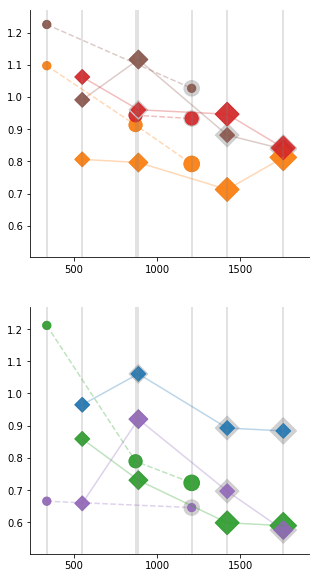

In [12]:
f,axs = plt.subplots(2,1, figsize=(5,10), sharey=True)
for ax_id,toplot in enumerate([means_1, means_2]):

    for x in toplot["Sizes"].unique():
        axs[ax_id].axvline(x, alpha=.3, color="gray")
        
    for i,subdf in toplot.groupby(["Phenotype", "Shape"]):
        temp = subdf.sort_values("Sizes")
        temp = temp.dropna()
        if subdf["Shape"].values[0] == "o":
            ls = "--"
        else: 
            ls = "-"
            
        if len(temp)>0:
            axs[ax_id].plot(temp["Sizes"], temp["Val"], c=temp["Colors"].values[0], alpha=.3, ls=ls)
    
    for markertype in toplot["Shape"].unique():
        subdf = toplot[toplot["Shape"]==markertype]
        axs[ax_id].scatter(subdf["Sizes"], subdf["Val"], c=subdf["Light_Colors"], marker=markertype, s=subdf["Sizes"]/5, alpha=.9)#, edgecolors=subdf["Colors"])
        axs[ax_id].scatter(subdf["Sizes"], subdf["Val"], c=subdf["Colors"], marker=markertype, s=subdf["num_labels"]/5, alpha=.9)

    axs[ax_id].spines['right'].set_visible(False)
    axs[ax_id].spines['top'].set_visible(False)
    axs[ax_id].xaxis.set_major_locator(plt.MaxNLocator(4))
    axs[ax_id].set_facecolor("None")

